In [7]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import f1_score
import time
import dill

sys.path.insert(1, os.path.join(sys.path[0], "code/implementation"))
from layer_v2 import Layer
from neural_network_v2 import NeuralNetwork

# Helper functions

In [3]:
def visualize_fit_of_regression(data_frame, neural, std):
    y = neural.predict(data_frame["x"])
    plt.scatter(data_frame["x"], y, c="red")
    plt.scatter(data_frame["x"], data_frame["y"], c="blue")
    plt.legend(["Prediction", "True"])
    return neural.calculate_cost(data_frame["x"], data_frame["y"]) * std["y"] ** 2

In [109]:
def visualize_correctness(train, test, title=""):

    # visualizing the data
    plt.figure(figsize=(10, 5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    if len(train["correct"].drop_duplicates()) == 1:
        if train["correct"].drop_duplicates().values[0]:
            color = "g"
        else:
            color = "r"
        plt.scatter(train["x"], train["y"], c=color)
    else:
        plt.scatter(
            train["x"],
            train["y"],
            c=train["correct"],
            cmap=LinearSegmentedColormap.from_list("rg", ["r", "w", "g"], N=256),
        )
    plt.title("Training Data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.subplot(1, 2, 2)
    plt.scatter(
        test["x"],
        test["y"],
        c=test["correct"],
        cmap=LinearSegmentedColormap.from_list("rg", ["r", "w", "g"], N=256),
    )
    plt.title("Test Data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [110]:
def visualize_data_distribution(train, test, title="", color_by="c"):
    # visualizing the data
    plt.figure(figsize=(10, 5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.scatter(
        train["x"],
        train["y"],
        c=train[color_by],
        cmap="viridis",
    )
    plt.title("Training Data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.subplot(1, 2, 2)
    plt.scatter(
        test["x"],
        test["y"],
        c=test[color_by],
        cmap="viridis",
    )
    plt.title("Test Data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

# Multimodal

In [4]:
multimodal_train = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/regression/multimodal-large-training.csv"
)
multimodal_test = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/regression/multimodal-large-test.csv"
)
mean = multimodal_train.mean()
std = multimodal_train.std()
multimodal_train = (multimodal_train - mean) / std
multimodal_test = (multimodal_test - mean) / std

## Joke but works surprisingly well  

In [5]:
neural = NeuralNetwork(cost_function="mse")
neural.add_layer(Layer(1, 10, "relu"))
neural.add_layer(Layer(10, 20, "relu"))
neural.add_layer(Layer(20, 100, "relu"))
neural.add_layer(Layer(100, 1, "linear"))
mse = neural.train(multimodal_test["x"], multimodal_test["y"], max_num_epoch=1500, learning_rate=0.001)

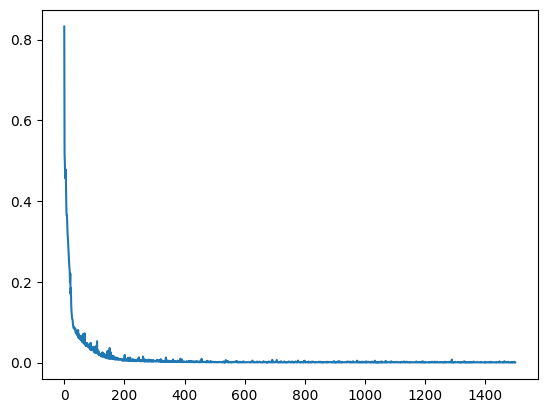

In [6]:
plt.plot(mse)

3.7861997579177413

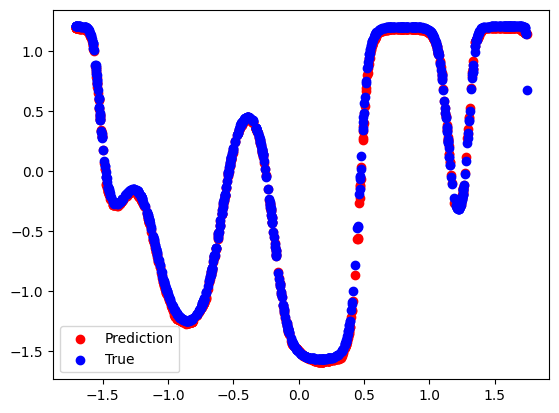

In [7]:
visualize_fit_of_regression(multimodal_test, neural, std)

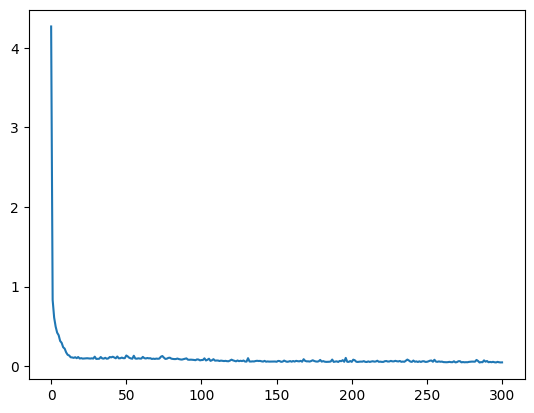

In [8]:
neural = NeuralNetwork(cost_function="mse")
neural.add_layer(Layer(1, 10, "relu"))
neural.add_layer(Layer(10, 10, "relu"))
neural.add_layer(Layer(10, 1, "linear"))
mse = neural.train(
    multimodal_test["x"], multimodal_test["y"], max_num_epoch=300, learning_rate=0.01
)
plt.plot(mse)

257.7151700684677

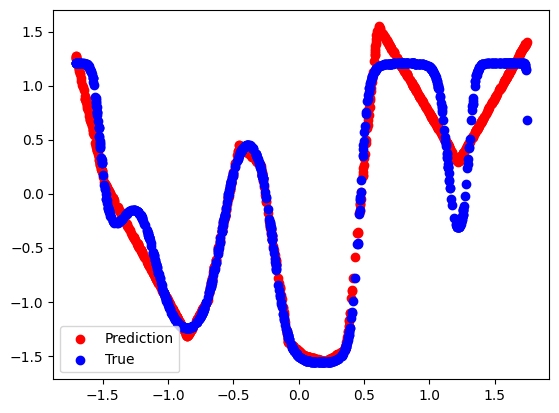

In [9]:
visualize_fit_of_regression(multimodal_test, neural, std)

## Proper analysis 

In [10]:
activation_functions = ["relu", "sigmoid", "tanh", "linear", "leaky_relu"]
initialization_methods = [
    "normal",
    "uniform_xavier",
    "he",
    "normal_xavier",
    "uniform_minus_one_one",
    "uniform_zero_one",
]
number_of_repetition = 2 # 10

In [70]:
from collections import defaultdict 
df = pd.DataFrame(columns=["Initialization", "Activation", "Hidden Layers", "Cost", "Computation Time"])
after_epoch_dict = defaultdict(lambda: []) 

for initialization_method in initialization_methods:
    for activation in activation_functions:
        for _ in range(number_of_repetition):
            # One hidden layer creation
            one_hidden = NeuralNetwork(cost_function="mse")
            one_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            one_hidden.add_layer(Layer(10, 1, "linear"))

            # Two hidden layers creation
            two_hidden = NeuralNetwork(cost_function="mse")
            two_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            two_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            two_hidden.add_layer(Layer(10, 1, "linear"))

            # Three hidden layers creation
            three_hidden = NeuralNetwork(cost_function="mse")
            three_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(Layer(10, 1, "linear"))

            # Training
            time_start = time.time()
            one_cost_after_epoch = one_hidden.train(
                multimodal_train["x"],
                multimodal_train["y"],
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_first = time.time() - time_start
            two_cost_after_epoch = two_hidden.train(
                multimodal_train["x"],
                multimodal_train["y"],
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_second = time.time() - time_start - time_first
            three_cost_after_epoch = three_hidden.train(
                multimodal_train["x"],
                multimodal_train["y"],
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_third = time.time() - time_start - time_first - time_second

            # Testing
            one_hidden_test_cost = one_hidden.calculate_cost(
                multimodal_test["x"], multimodal_test["y"]
            )
            two_hidden_test_cost = two_hidden.calculate_cost(
                multimodal_test["x"], multimodal_test["y"]
            )
            three_hidden_test_cost = three_hidden.calculate_cost(
                multimodal_test["x"], multimodal_test["y"]
            )

            # Saving cost after training results
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "1",
                one_hidden_test_cost,
                time_first
            ]
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "2",
                two_hidden_test_cost,
                time_second
            ]
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "3",
                three_hidden_test_cost,
                time_third
            ]
            
            # Saving cost after epoch results
            after_epoch_dict[
                f"{initialization_method}/{activation}/1"
            ].append(one_cost_after_epoch)
            after_epoch_dict[
                f"{initialization_method}/{activation}/2"
            ].append(two_cost_after_epoch)
            after_epoch_dict[
                f"{initialization_method}/{activation}/3"
            ].append(three_cost_after_epoch)
    print(f"Initialization method {initialization_method} done")

Initialization method normal done
Initialization method uniform_xavier done
Initialization method he done
Initialization method normal_xavier done
Initialization method uniform_minus_one_one done
Initialization method uniform_zero_one done


### saving results

This trick was used because calculations were done on google colab thats, why saving part is commented out, i don't want to overwrite it 

In [82]:
# df.to_csv("results.csv", index=False)

# import dill
# with open("after_epoch_dict.pkl", "wb") as f:
#     dill.dump(after_epoch_dict, f)

### loading results

In [8]:
df = pd.read_csv("results.csv")
after_epoch_dict = dill.load(open("after_epoch_dict.pkl", "rb"))

## Graphing multimodal

Text(0.5, 1.0, 'Cost of Neural Network with Different Activation Functions and Hidden Layers with He Initialization')

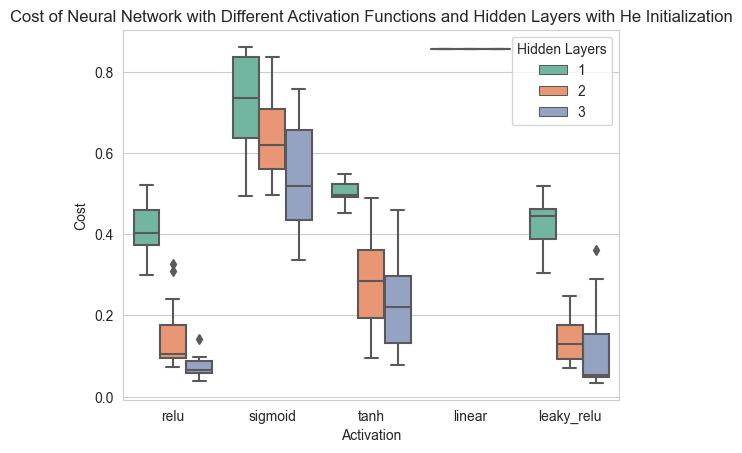

In [101]:
import seaborn as sns
sns.set_style("whitegrid")
df_he = df[df["Initialization"] == "he"]
sns.boxplot(x="Activation", y="Cost", data=df_he, hue="Hidden Layers", palette="Set2")
plt.title(
    "Cost of Neural Network with Different Activation Functions and Hidden Layers with He Initialization"
)

Text(0.5, 1.0, 'Cost of Neural Network with Different Activation Functions and Hidden Layers with Normal Xavier Initialization')

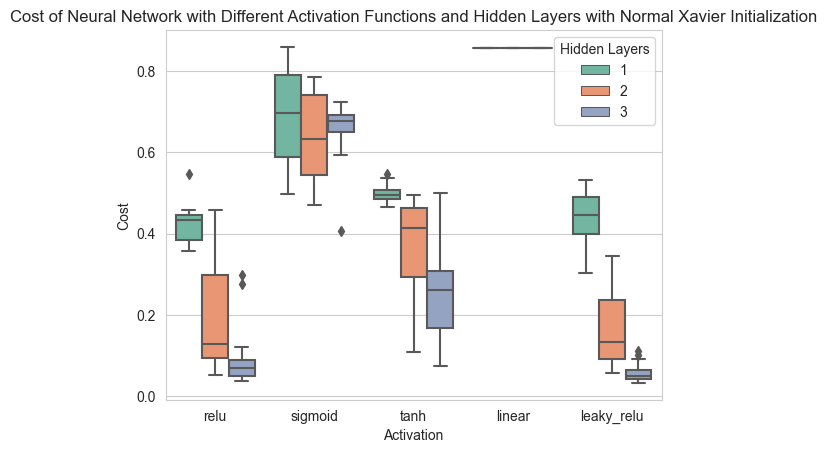

In [102]:
import seaborn as sns

sns.set_style("whitegrid")
df_he = df[df["Initialization"] == "normal_xavier"]
sns.boxplot(x="Activation", y="Cost", data=df_he, hue="Hidden Layers", palette="Set2")
plt.title(
    "Cost of Neural Network with Different Activation Functions and Hidden Layers with Normal Xavier Initialization"
)

Text(0.5, 1.0, 'Cost of Neural Network with Different Initialization Functions and Hidden Layers with ReLU Activation')

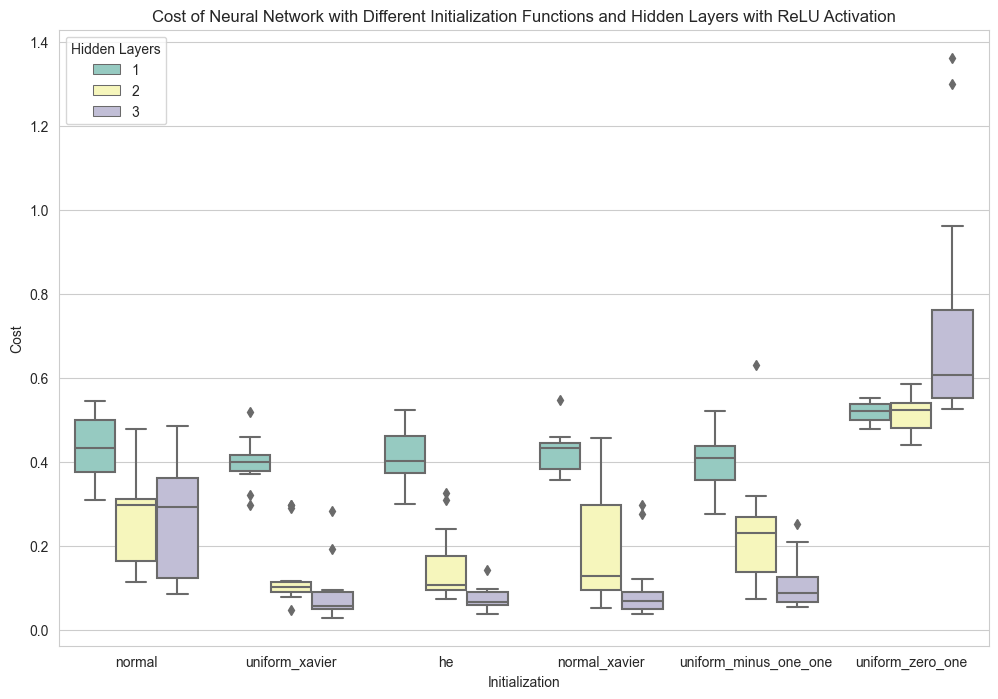

In [106]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
df_he = df[df["Activation"] == "relu"]
sns.boxplot(
    x="Initialization", y="Cost", data=df_he, hue="Hidden Layers", palette="Set3"
)
plt.title(
    "Cost of Neural Network with Different Initialization Functions and Hidden Layers with ReLU Activation"
)

Text(0.5, 1.0, 'Cost of Neural Network with Different Initialization Functions and Hidden Layers with sigmoid Activation')

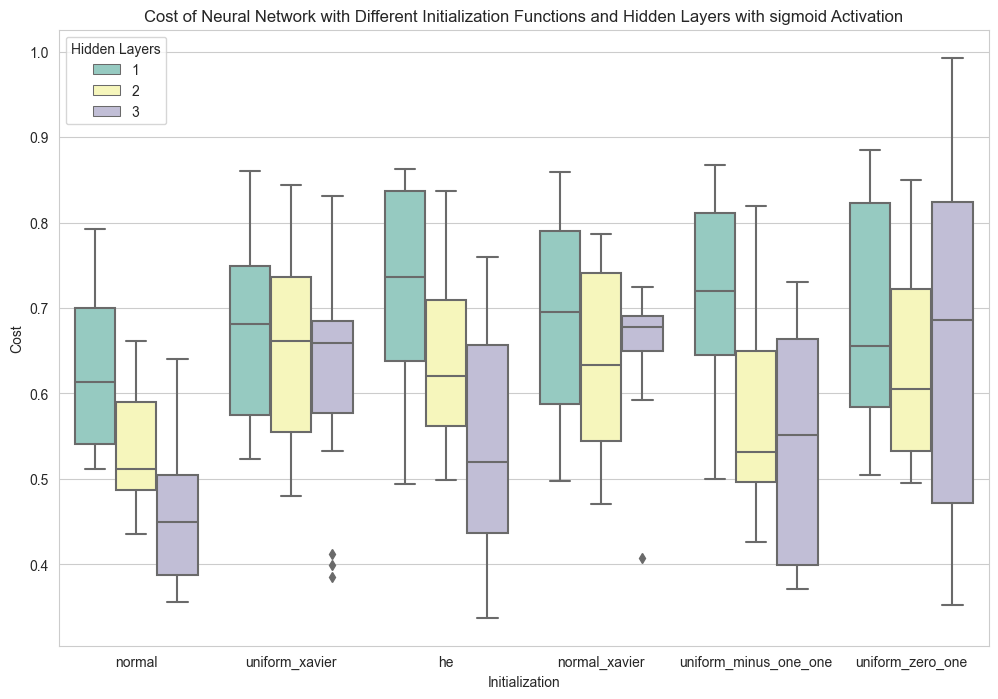

In [112]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
df_sigmoid = df[df["Activation"] == "sigmoid"]
sns.boxplot(
    x="Initialization", y="Cost", data=df_sigmoid, hue="Hidden Layers", palette="Set3"
)
plt.title(
    "Cost of Neural Network with Different Initialization Functions and Hidden Layers with sigmoid Activation"
)

Text(0.5, 1.0, 'Time of computing 200 epoch of Neural Network with different activation function and Hidden Layer')

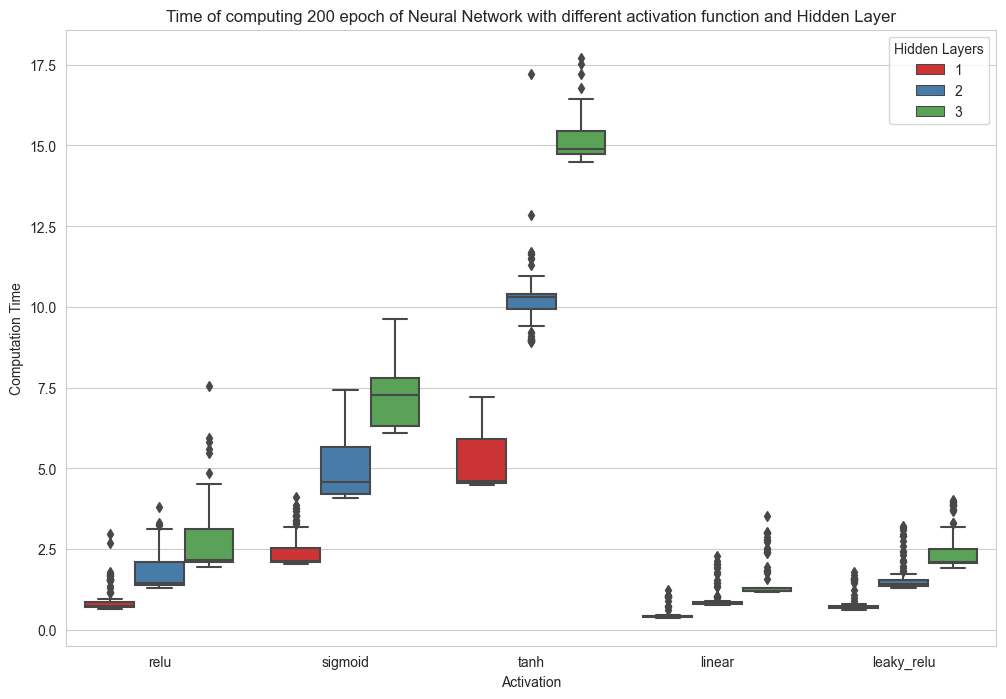

In [118]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.boxplot(
    x="Activation", y="Computation Time", data=df, hue="Hidden Layers", palette="Set1"
)
plt.title(
    "Time of computing 200 epoch of Neural Network with different activation function and Hidden Layer"
)

Text(0, 0.5, 'MSE')

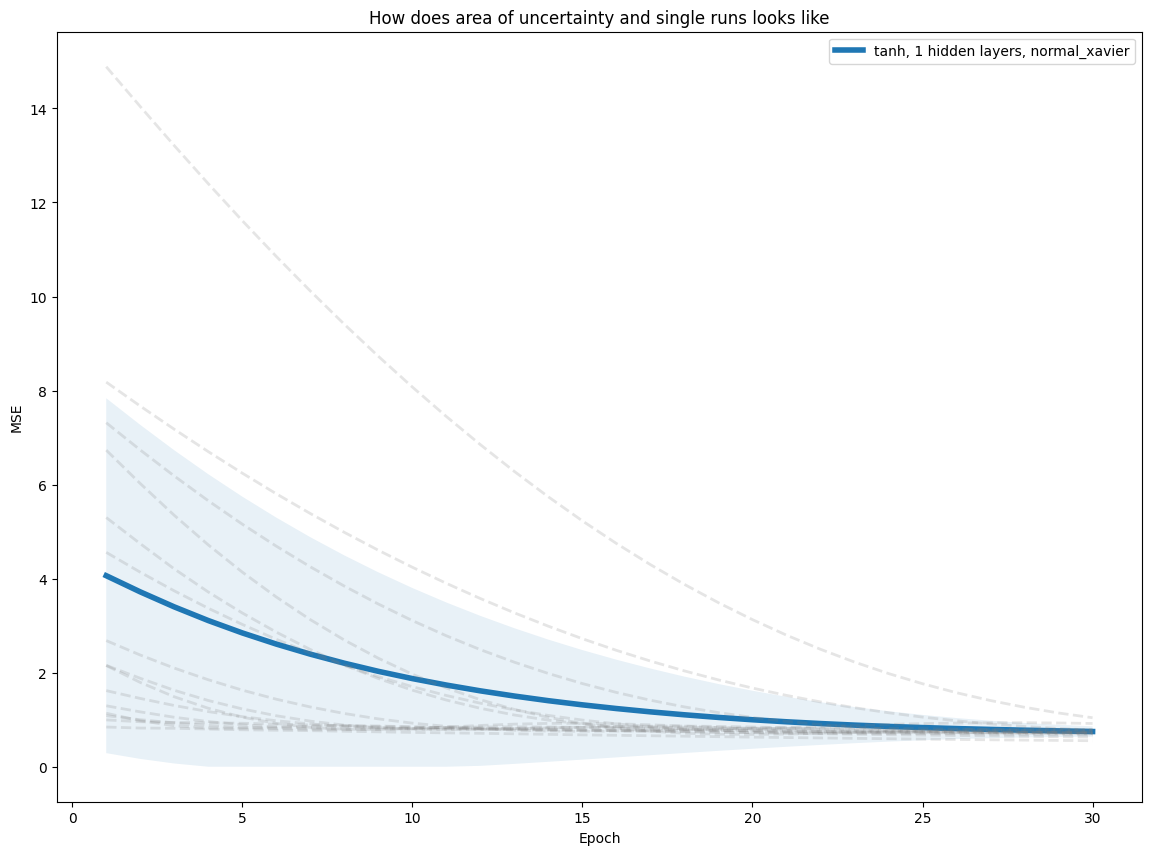

In [76]:
plt.figure(figsize=(14, 10))
start = 1
stop = 31  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers, {key[0]}"
    if (
        key[0] in ["normal_xavier"]
        and key[1] in ["tanh"]
        and key[2] in ["1"]
    ):
        plt.plot(
            range(start, stop),
            np.mean(value, axis=0)[start:stop],
            label=label,
            linewidth=4,
        )

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
        )

        for single_run in value:
            plt.plot(range(start, stop), single_run[start:stop], alpha=0.2, c="gray", linewidth=2, linestyle="--")

plt.legend()
plt.title("How does area of uncertainty and single runs looks like")
plt.xlabel("Epoch")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

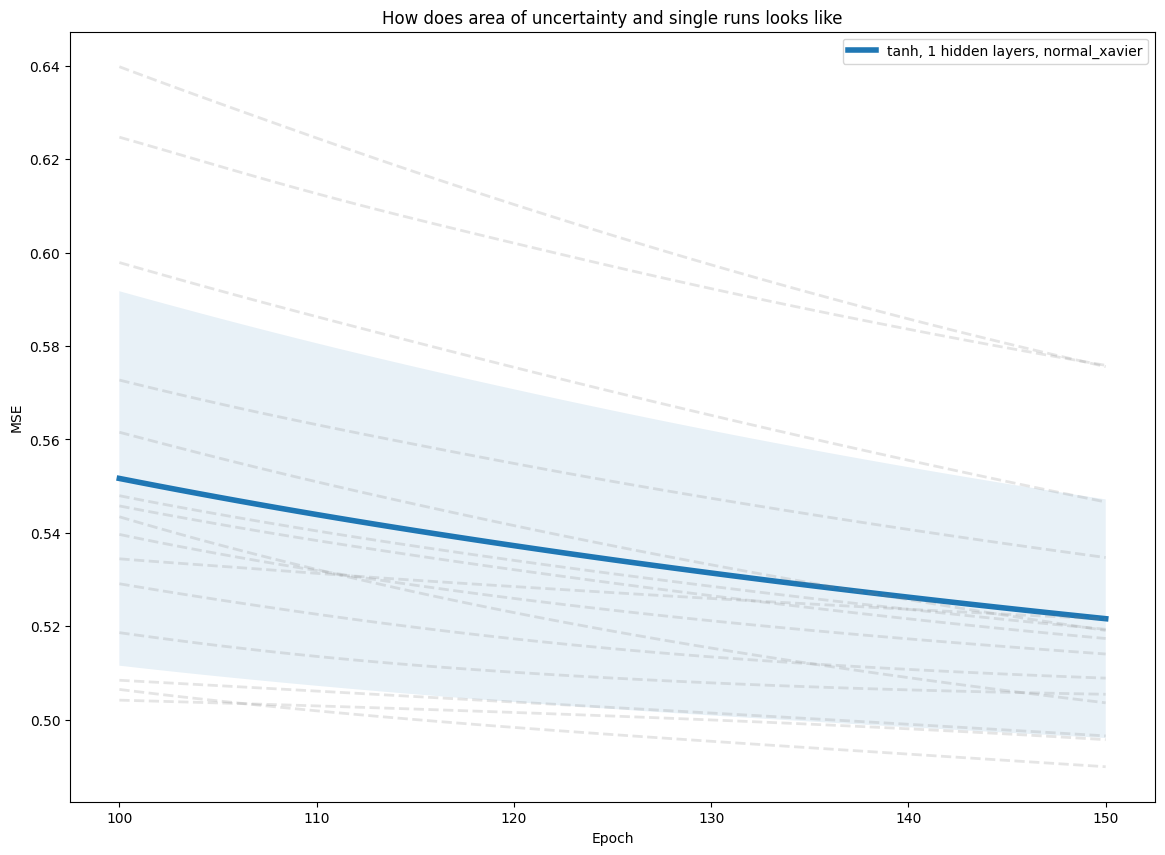

In [78]:
plt.figure(figsize=(14, 10))
start = 100
stop = 151  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers, {key[0]}"
    if key[0] in ["normal_xavier"] and key[1] in ["tanh"] and key[2] in ["1"]:
        plt.plot(
            range(start, stop),
            np.mean(value, axis=0)[start:stop],
            label=label,
            linewidth=4,
        )

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
        )

        for single_run in value:
            plt.plot(
                range(start, stop),
                single_run[start:stop],
                alpha=0.2,
                c="gray",
                linewidth=2,
                linestyle="--",
            )

plt.legend()
plt.title("How does area of uncertainty and single runs looks like")
plt.xlabel("Epoch")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

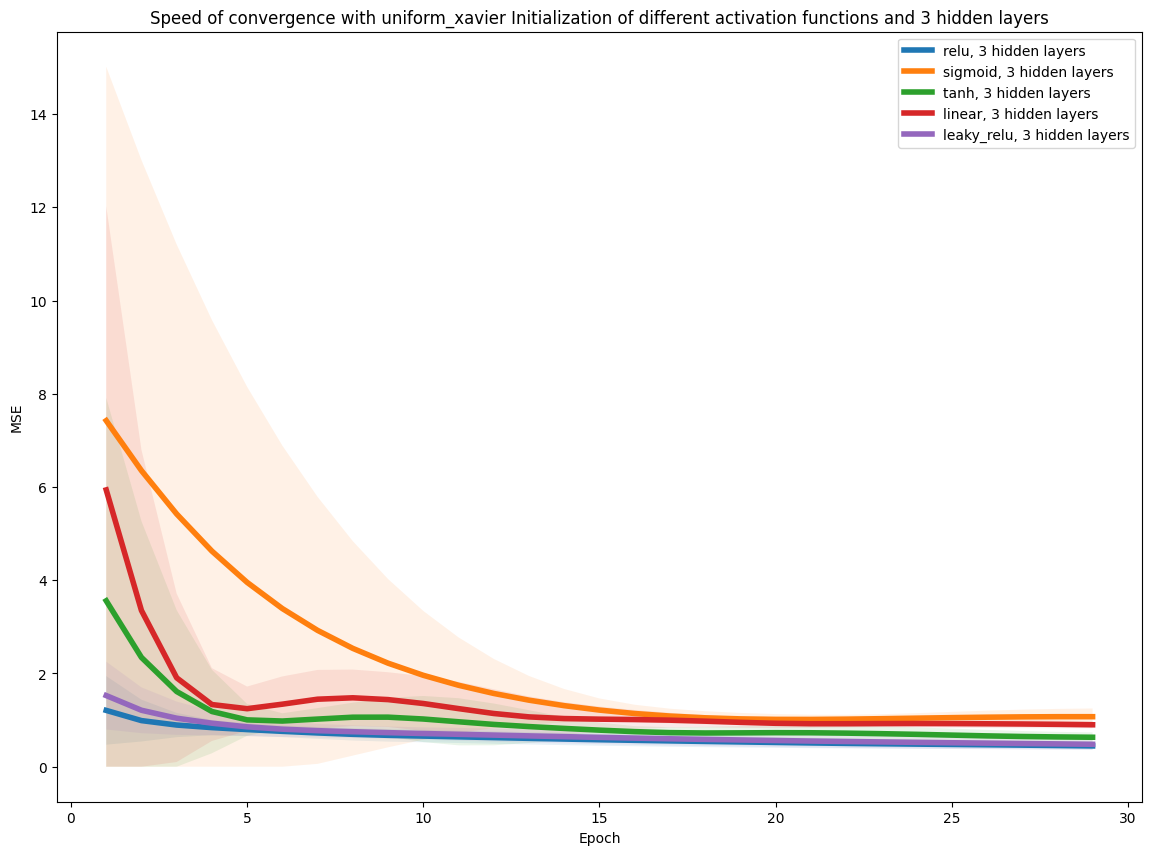

In [41]:
plt.figure(figsize=(14, 10))
start = 1
stop = 30  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers"
    if (
        key[0] in ["uniform_xavier"]
        and key[1] in ["tanh", "relu", "sigmoid", "leaky_relu", "linear"]
        and key[2] in ["3"]
    ):
        plt.plot(
            range(start, stop),
            np.mean(value, axis=0)[start:stop],
            label=label,
            linewidth=4,
        )

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
        )

plt.legend()
plt.title(
    "Speed of convergence with uniform_xavier Initialization of different activation functions and 3 hidden layers"
)
plt.xlabel("Epoch")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

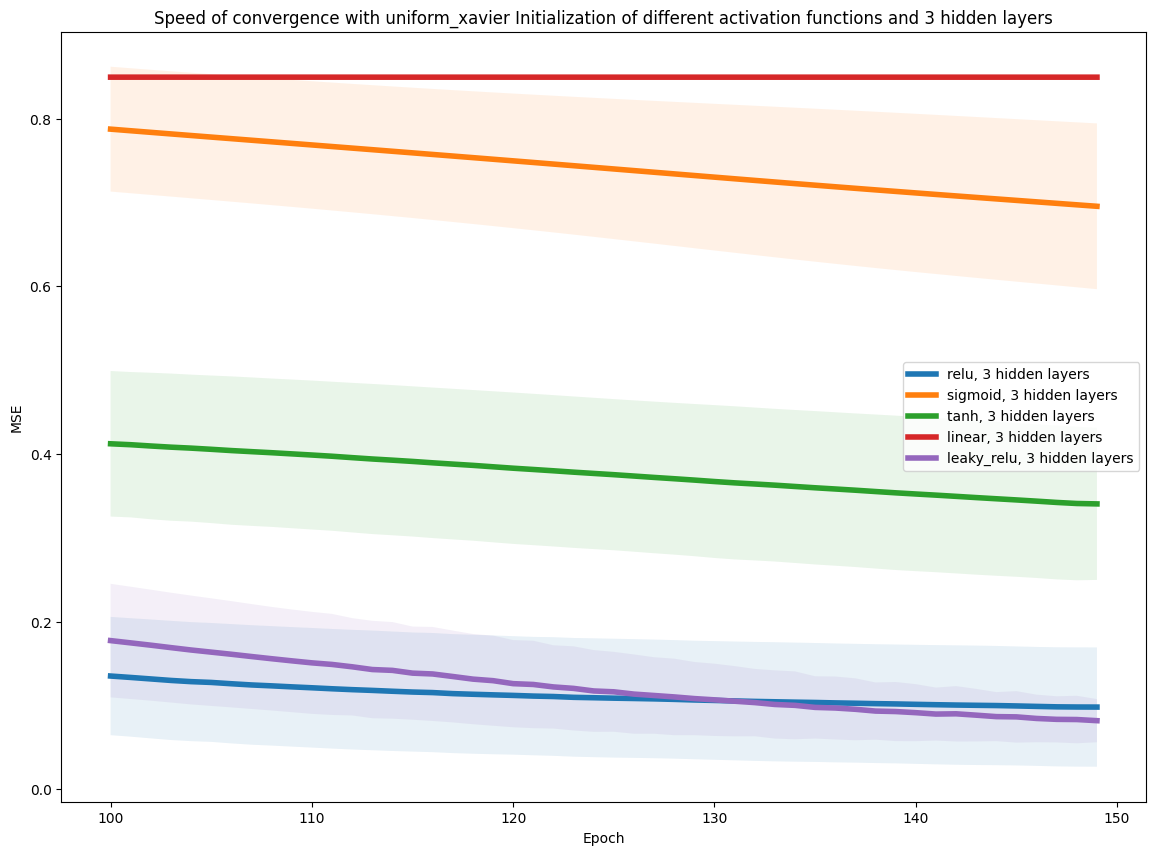

In [38]:
plt.figure(figsize=(14, 10))
start = 100
stop = 150 #len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key  = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers"
    if key[0] in ["uniform_xavier"] and key[1] in ["tanh", "relu", "sigmoid", "leaky_relu", "linear"] and key[2] in ["3"]:
        plt.plot(range(start,stop), np.mean(value, axis=0)[start:stop], label=label, linewidth=4)
                                                      
        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value,axis=0)[start:stop],
            alpha=0.1,
        )

plt.legend()
plt.title(
    "Speed of convergence with uniform_xavier Initialization of different activation functions and 3 hidden layers"
)
plt.xlabel("Epoch")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

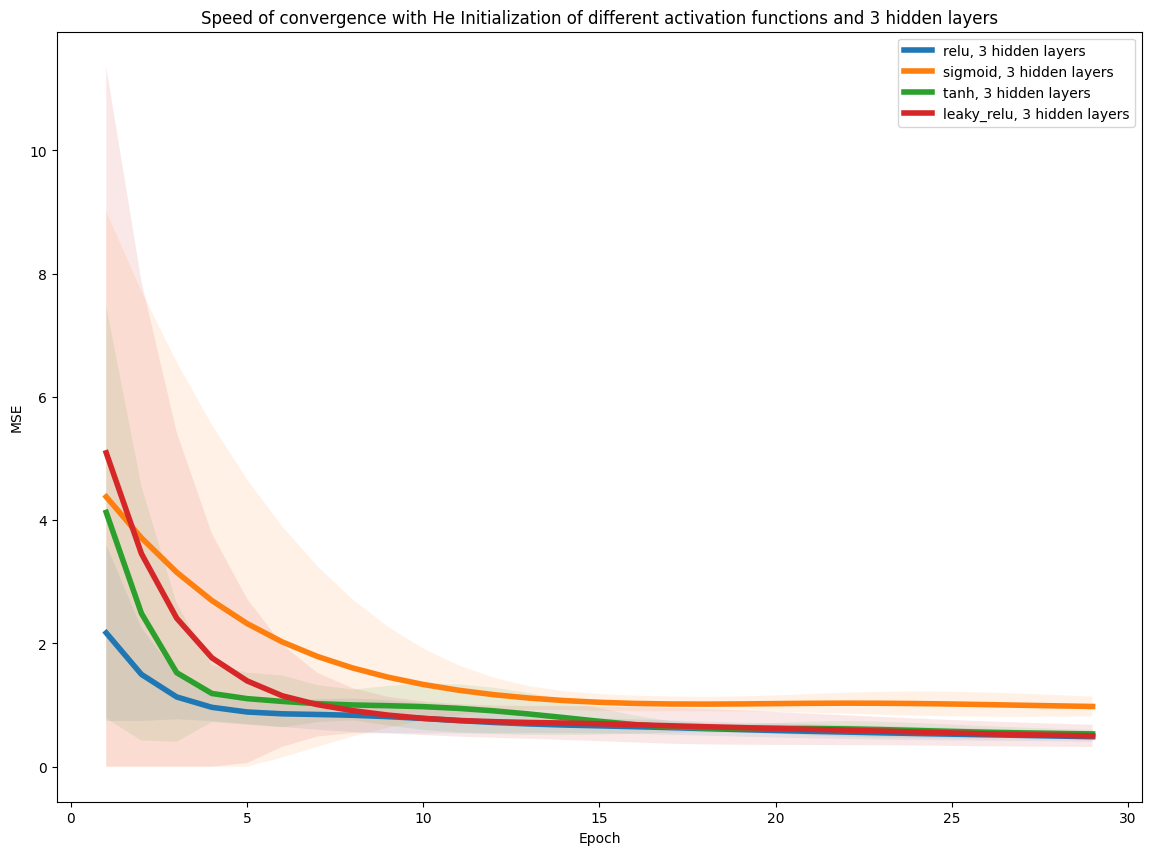

In [44]:
plt.figure(figsize=(14, 10))
start = 1
stop = 30  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers"
    if (
        key[0] in ["he"]
        and key[1] in ["tanh", "relu", "sigmoid", "leaky_relu"]
        and key[2] in ["3"]
    ):
        plt.plot(range(start, stop), np.mean(value, axis=0)[start:stop], label=label, linewidth=4)

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
        )

plt.legend()
plt.title(
    "Speed of convergence with He Initialization of different activation functions and 3 hidden layers"
)
plt.xlabel("Epoch")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

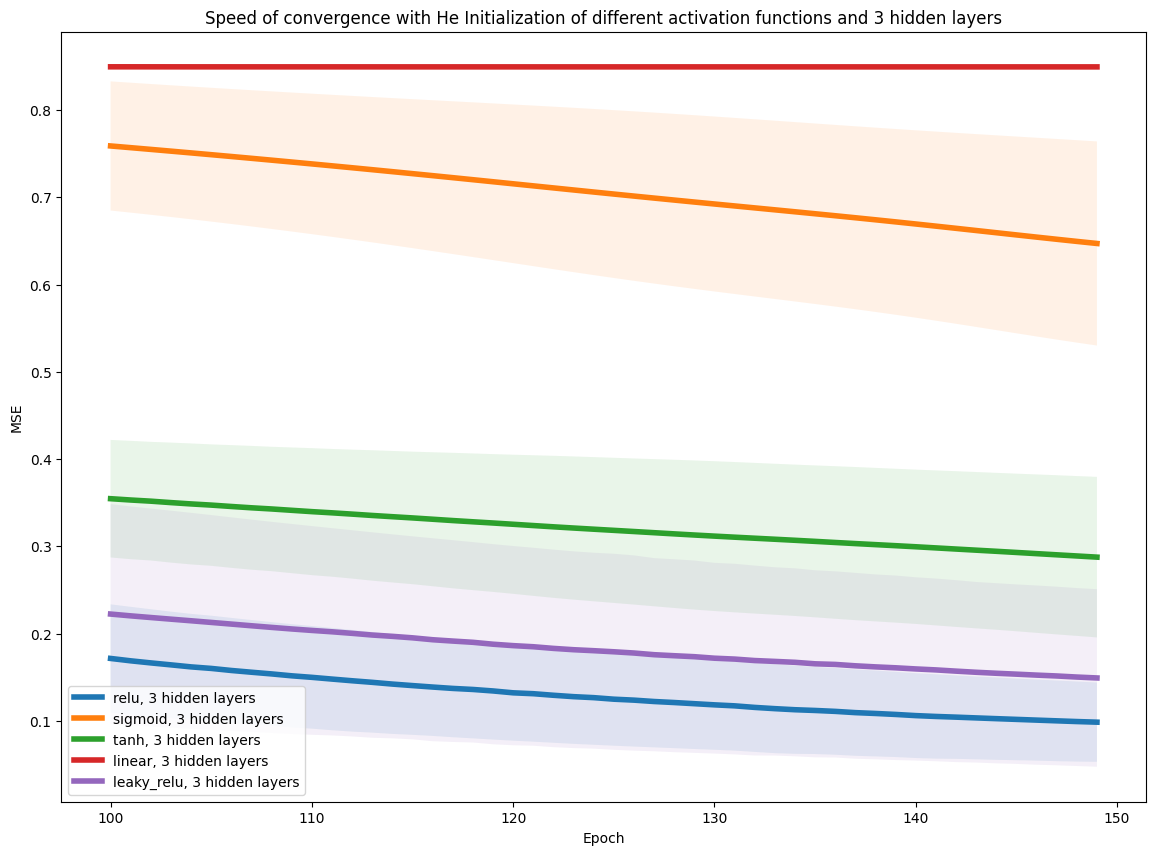

In [37]:
plt.figure(figsize=(14, 10))
start = 100
stop = 150  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers"
    if (
        key[0] in ["he"]
        and key[1] in ["tanh", "relu", "sigmoid", "leaky_relu", "linear"]
        and key[2] in ["3"]
    ):
        plt.plot(range(start, stop), np.mean(value, axis=0)[start:stop], label=label, linewidth=4)

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
        )

plt.legend()
plt.title(
    "Speed of convergence with He Initialization of different activation functions and 3 hidden layers"
)
plt.xlabel("Epoch")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

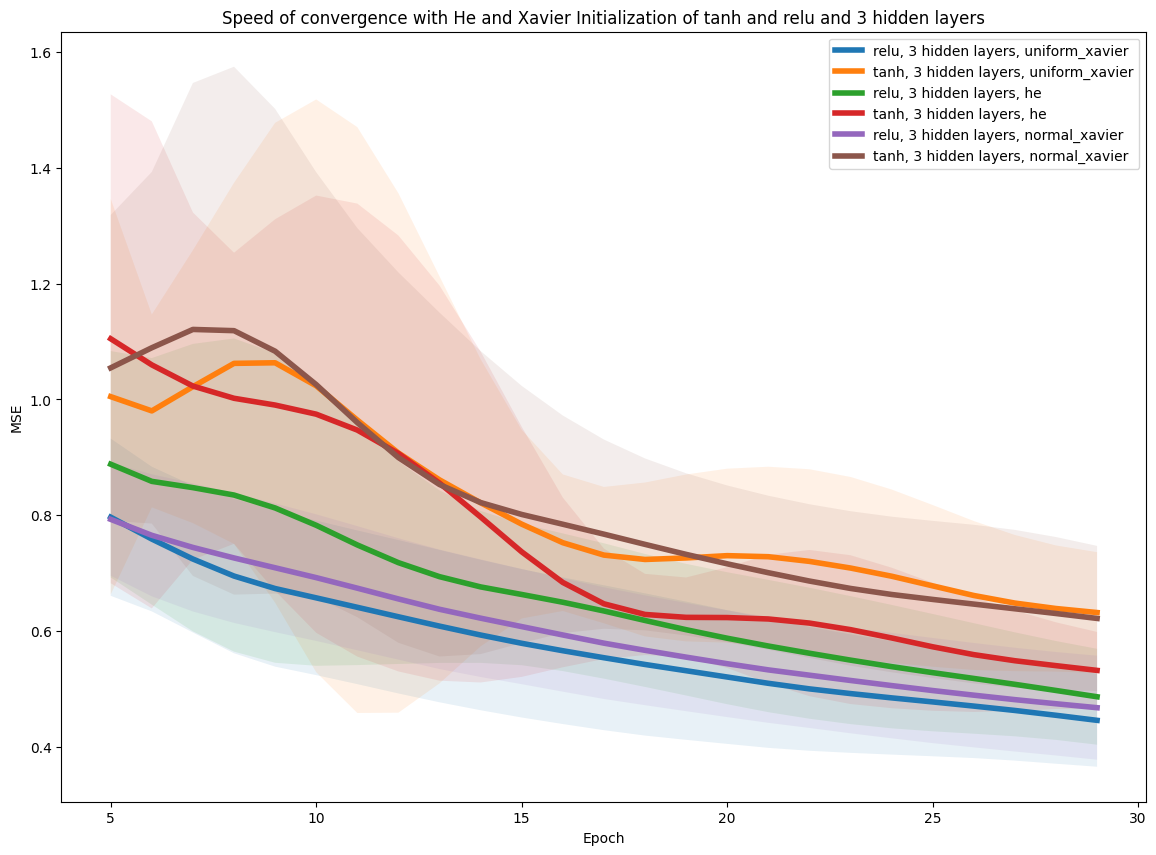

In [45]:
plt.figure(figsize=(14, 10))
start = 5
stop = 30  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers, {key[0]}"
    if (
        key[0] in ["he", "normal_xavier", "uniform_xavier"]
        and key[1] in ["tanh", "relu"]
        and key[2] in ["3"]
    ):
        plt.plot(range(start, stop), np.mean(value, axis=0)[start:stop], label=label, linewidth=4)

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
        )

plt.legend()
plt.title(
    "Speed of convergence with He and Xavier Initialization of tanh and relu and 3 hidden layers"
)
plt.xlabel("Epoch")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

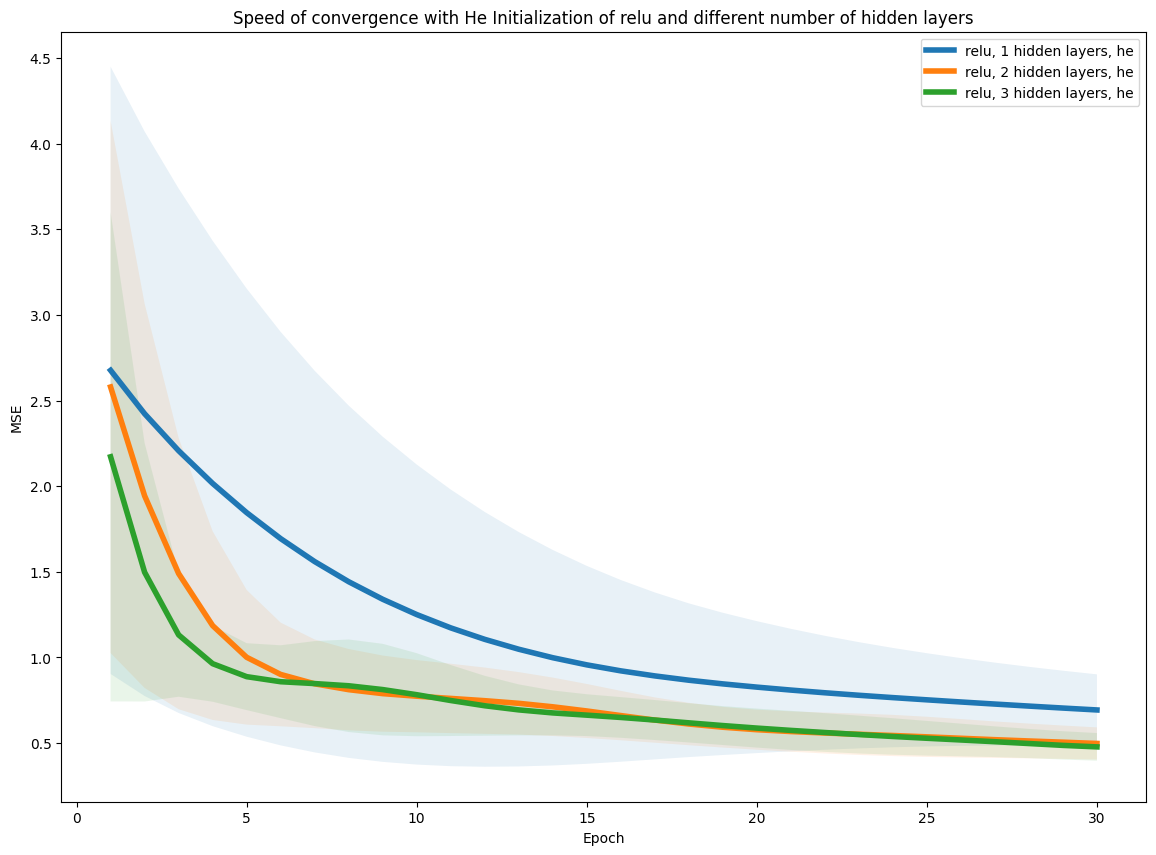

In [60]:
plt.figure(figsize=(14, 10))
start = 1
stop = 31  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers, {key[0]}"
    if (
        key[0] in ["he"]
        and key[1] in ["relu"]
        and key[2] in ["1", "2", "3"]
    ):
        plt.plot(
            range(start, stop),
            np.mean(value, axis=0)[start:stop],
            label=label,
            linewidth=4,
        )

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
        )

plt.legend()
plt.title(
    "Speed of convergence with He Initialization of relu and different number of hidden layers"
)
plt.xlabel("Epoch")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

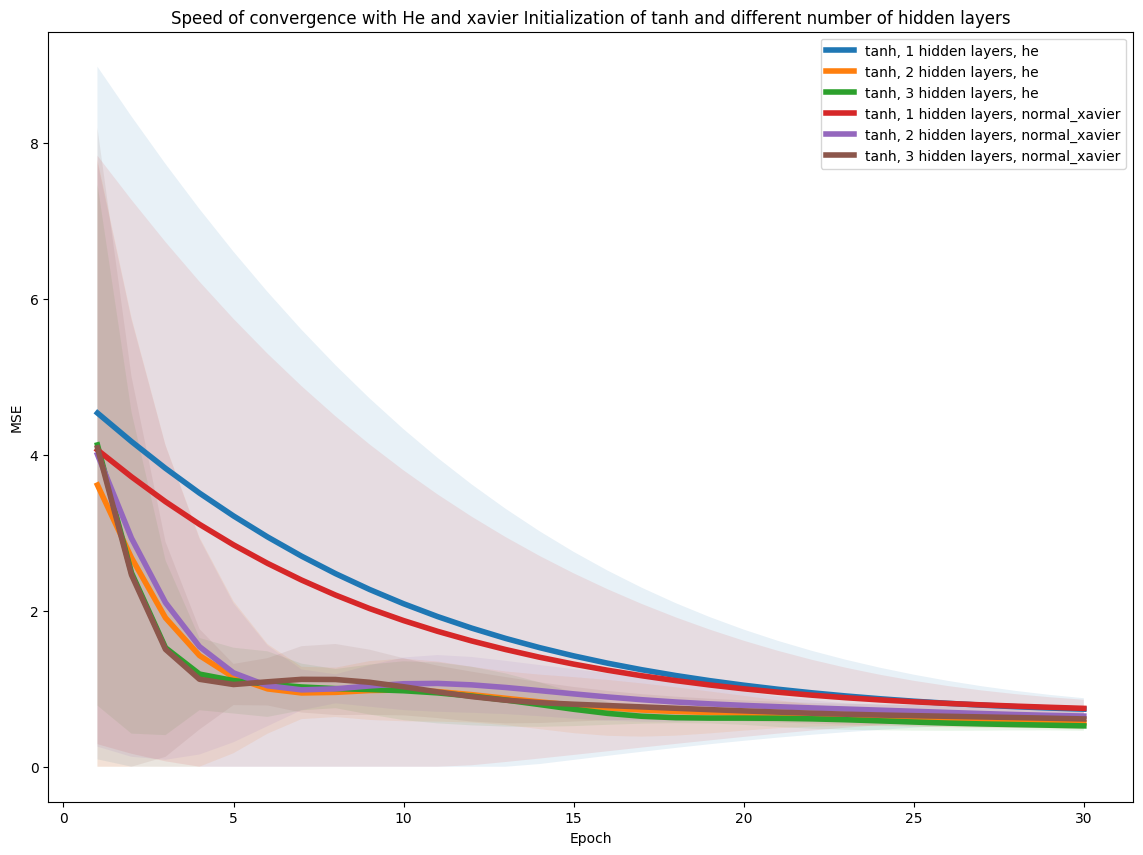

In [63]:
plt.figure(figsize=(14, 10))
start = 1
stop = 31  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers, {key[0]}"
    if key[0] in ["normal_xavier", "he"] and key[1] in ["tanh"] and key[2] in ["1", "2", "3"]:
        plt.plot(
            range(start, stop),
            np.mean(value, axis=0)[start:stop],
            label=label,
            linewidth=4,
        )

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
        )

plt.legend()
plt.title(
    "Speed of convergence with He and xavier Initialization of tanh and different number of hidden layers"
)
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Steps large

In [82]:
steps_large_train = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/regression/steps-large-test.csv"
)
steps_large_test = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/regression/steps-large-training.csv"
)
mean = steps_large_train.mean()
std = steps_large_train.std()
steps_large_train = (steps_large_train - mean) / std
steps_large_test = (steps_large_test - mean) / std

In [84]:
activation_functions = ["relu", "tanh", "leaky_relu"]
initialization_methods = [
    "uniform_xavier",
    "he",
    "normal_xavier"
]
number_of_repetition = 15
data = steps_large_train
data_test = steps_large_test

In [85]:
from collections import defaultdict

df = pd.DataFrame(
    columns=[
        "Initialization",
        "Activation",
        "Hidden Layers",
        "Cost",
        "Computation Time",
    ]
)
after_epoch_dict = defaultdict(lambda: [])

for initialization_method in initialization_methods:
    for activation in activation_functions:
        for _ in range(number_of_repetition):
            # One hidden layer creation
            one_hidden = NeuralNetwork(cost_function="mse")
            one_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            one_hidden.add_layer(Layer(10, 1, "linear"))

            # Two hidden layers creation
            two_hidden = NeuralNetwork(cost_function="mse")
            two_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            two_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            two_hidden.add_layer(Layer(10, 1, "linear"))

            # Three hidden layers creation
            three_hidden = NeuralNetwork(cost_function="mse")
            three_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(Layer(10, 1, "linear"))

            # Training
            time_start = time.time()
            one_cost_after_epoch = one_hidden.train(
                data["x"],
                data["y"],
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_first = time.time() - time_start
            two_cost_after_epoch = two_hidden.train(
                data["x"],
                data["y"],
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_second = time.time() - time_start - time_first
            three_cost_after_epoch = three_hidden.train(
                data["x"],
                data["y"],
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_third = time.time() - time_start - time_first - time_second

            # Testing
            one_hidden_test_cost = one_hidden.calculate_cost(
                data_test["x"], data_test["y"]
            )
            two_hidden_test_cost = two_hidden.calculate_cost(
                data_test["x"], data_test["y"]
            )
            three_hidden_test_cost = three_hidden.calculate_cost(
                data_test["x"], data_test["y"]
            )

            # Saving cost after training results
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "1",
                one_hidden_test_cost,
                time_first,
            ]
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "2",
                two_hidden_test_cost,
                time_second,
            ]
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "3",
                three_hidden_test_cost,
                time_third,
            ]

            # Saving cost after epoch results
            after_epoch_dict[f"{initialization_method}/{activation}/1"].append(
                one_cost_after_epoch
            )
            after_epoch_dict[f"{initialization_method}/{activation}/2"].append(
                two_cost_after_epoch
            )
            after_epoch_dict[f"{initialization_method}/{activation}/3"].append(
                three_cost_after_epoch
            )
    print(f"Initialization method {initialization_method} done")

Initialization method uniform_xavier done
Initialization method he done
Initialization method normal_xavier done


## visualization

Text(0, 0.5, 'MSE')

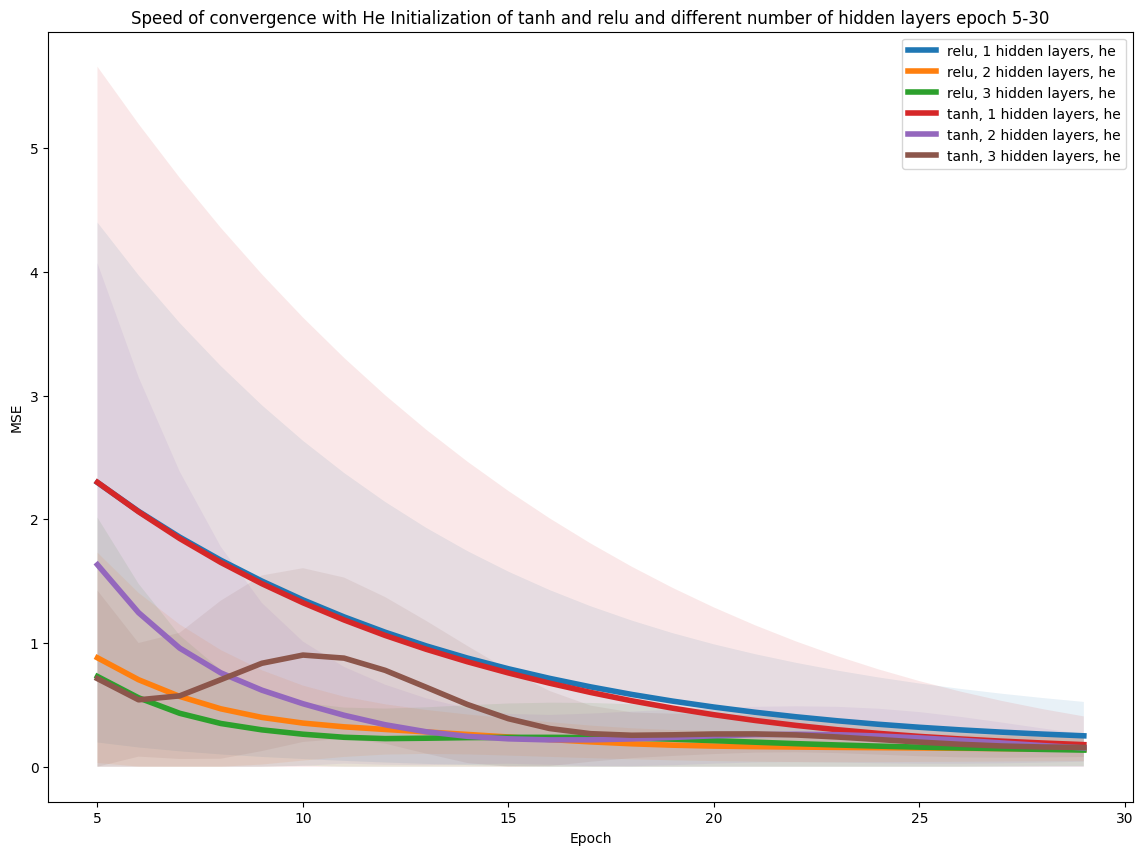

In [93]:
plt.figure(figsize=(14, 10))
start = 5
stop = 30  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers, {key[0]}"
    if (
        key[0] in ["he",]
        and key[1] in ["tanh", "relu"]
        and key[2] in ["1","2","3"]
    ):
        plt.plot(
            range(start, stop),
            np.mean(value, axis=0)[start:stop],
            label=label,
            linewidth=4,
        )

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
        )

plt.legend()
plt.title(
    "Speed of convergence with He Initialization of tanh and relu and different number of hidden layers epoch 5-30"
)
plt.xlabel("Epoch")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

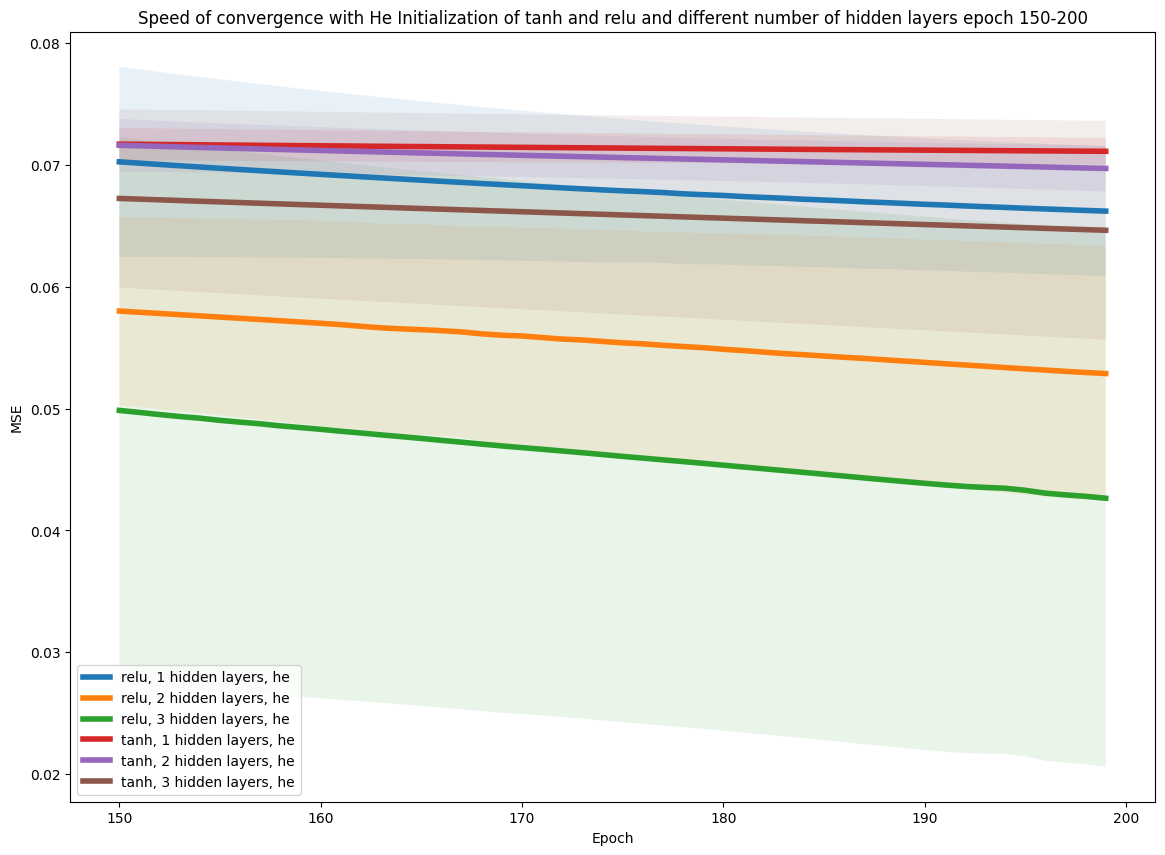

In [92]:
plt.figure(figsize=(14, 10))
start = 150
stop = 200  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers, {key[0]}"
    if (
        key[0]
        in [
            "he",
        ]
        and key[1] in ["tanh", "relu"]
        and key[2] in ["1", "2", "3"]
    ):
        plt.plot(
            range(start, stop),
            np.mean(value, axis=0)[start:stop],
            label=label,
            linewidth=4,
        )

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
        )

plt.legend()
plt.title(
    "Speed of convergence with He Initialization of tanh and relu and different number of hidden layers epoch 150-200"
)
plt.xlabel("Epoch")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

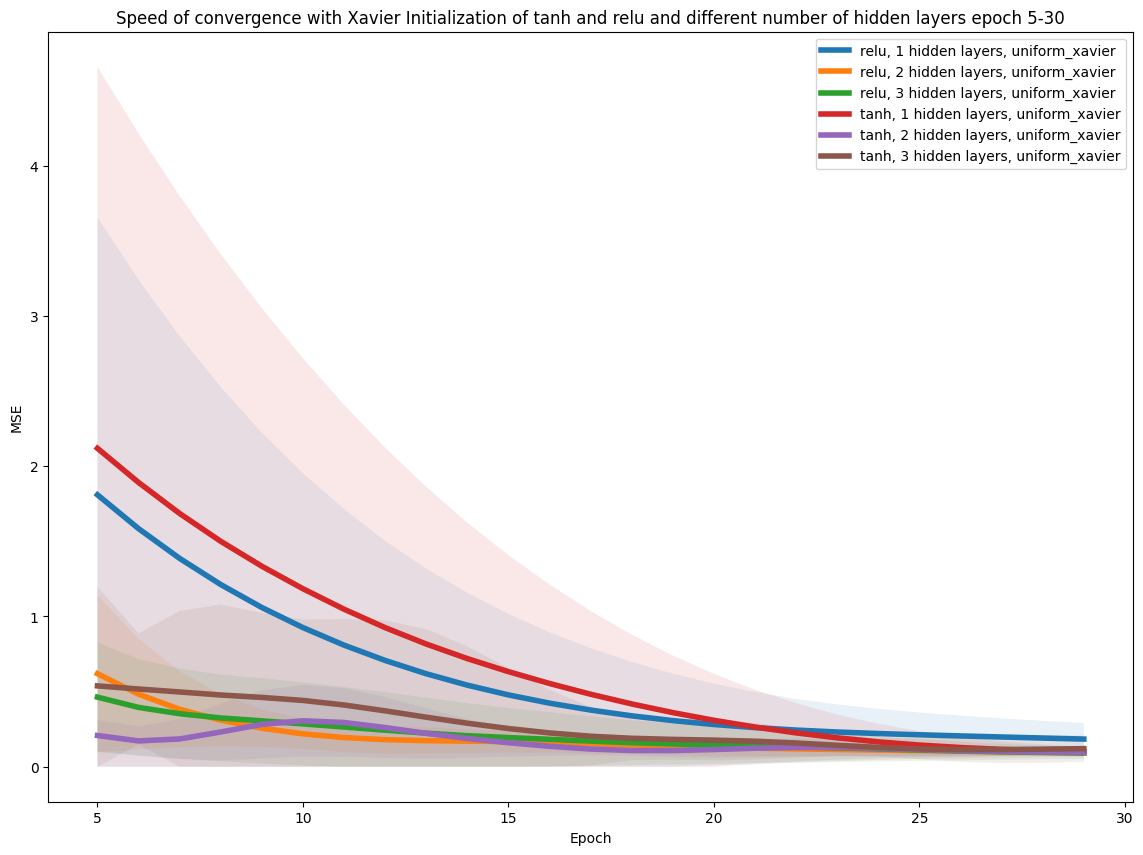

In [95]:
plt.figure(figsize=(14, 10))
start = 5
stop = 30  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers, {key[0]}"
    if (
        key[0]
        in [
            "uniform_xavier",
        ]
        and key[1] in ["tanh", "relu"]
        and key[2] in ["1", "2", "3"]
    ):
        plt.plot(
            range(start, stop),
            np.mean(value, axis=0)[start:stop],
            label=label,
            linewidth=4,
        )

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
        )

plt.legend()
plt.title(
    "Speed of convergence with Xavier Initialization of tanh and relu and different number of hidden layers epoch 5-30"
)
plt.xlabel("Epoch")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

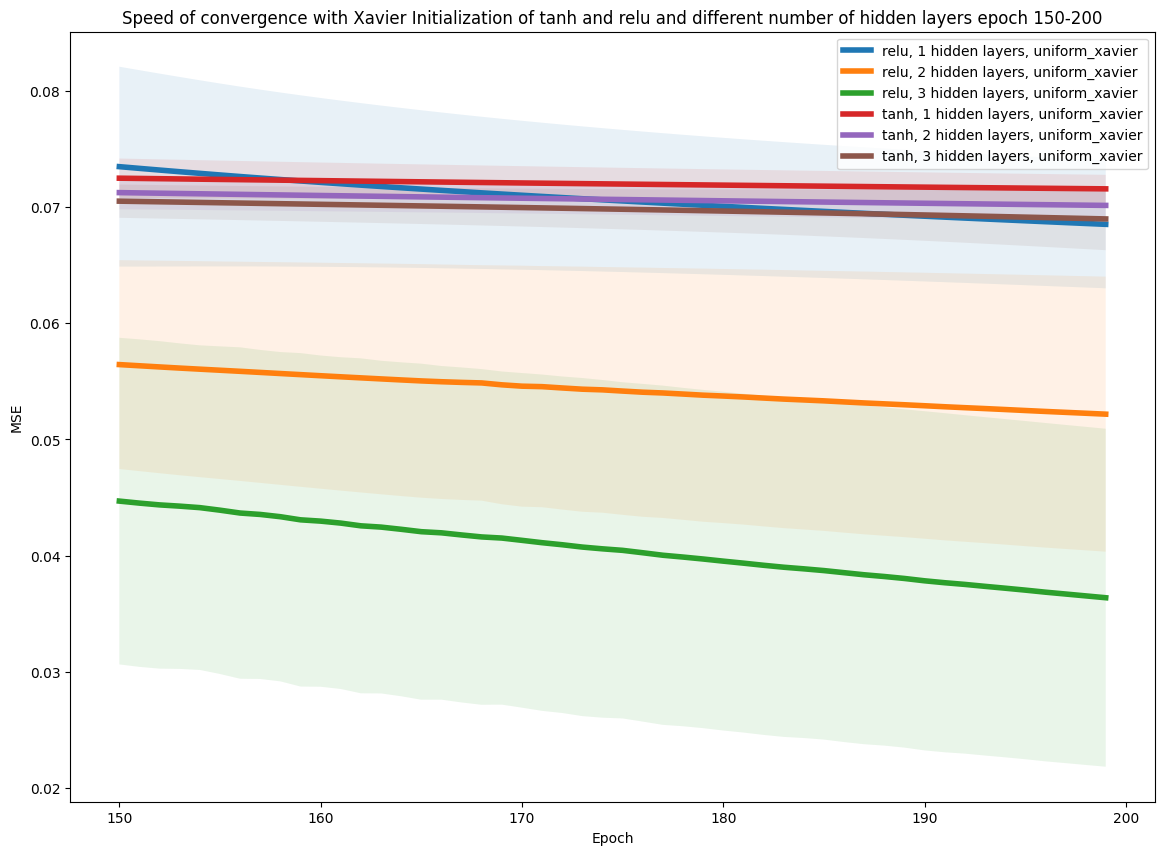

In [94]:
plt.figure(figsize=(14, 10))
start = 150
stop = 200  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers, {key[0]}"
    if (
        key[0]
        in [
            "uniform_xavier",
        ]
        and key[1] in ["tanh", "relu"]
        and key[2] in ["1", "2", "3"]
    ):
        plt.plot(
            range(start, stop),
            np.mean(value, axis=0)[start:stop],
            label=label,
            linewidth=4,
        )

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
        )

plt.legend()
plt.title(
    "Speed of convergence with Xavier Initialization of tanh and relu and different number of hidden layers epoch 150-200"
)
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Rings5

In [121]:
rings5_train = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/classification/rings5-regular-training.csv"
)
rings5_test = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/classification/rings5-regular-test.csv"
)
mean = rings5_train.mean()
std = rings5_train.std()
rings5_train[["x", "y"]] = (rings5_train[["x", "y"]] - mean[["x", "y"]]) / std[
    ["x", "y"]
]
rings5_test[["x", "y"]] = (rings5_test[["x", "y"]] - mean[["x", "y"]]) / std[["x", "y"]]

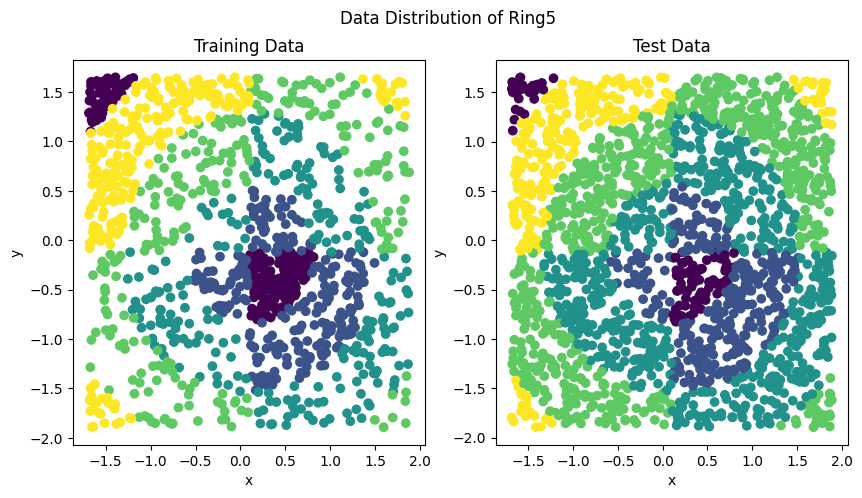

In [122]:
visualize_data_distribution(rings5_train, rings5_test, "Data Distribution of Ring5")

In [123]:
x = rings5_train[["x", "y"]].to_numpy()
y = rings5_train["c"].to_numpy().reshape(-1, 1)
# one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(y)
y = encoder.transform(y)

x_test = rings5_test[["x", "y"]].to_numpy()
y_test = rings5_test["c"].to_numpy().reshape(-1, 1)
# one-hot encoding
y_test = encoder.transform(y_test)

In [124]:
activation_functions = ["relu", "tanh"]
initialization_methods = ["uniform_xavier", "he"]
number_of_repetition = 15
data = rings5_train
data_test = rings5_test

In [125]:
from collections import defaultdict

df = pd.DataFrame(
    columns=[
        "Initialization",
        "Activation",
        "Hidden Layers",
        "Cost",
        "Computation Time",
    ]
)
after_epoch_dict = defaultdict(lambda: [])

for initialization_method in initialization_methods:
    for activation in activation_functions:
        for _ in range(number_of_repetition):
            # One hidden layer creation
            one_hidden = NeuralNetwork(cost_function="cross_entropy_with_softmax")
            one_hidden.add_layer(
                Layer(2, 10, activation, weight_initialization=initialization_method)
            )
            one_hidden.add_layer(Layer(10, 5, "softmax"))

            # Two hidden layers creation
            two_hidden = NeuralNetwork(cost_function="cross_entropy_with_softmax")
            two_hidden.add_layer(
                Layer(2, 10, activation, weight_initialization=initialization_method)
            )
            two_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            two_hidden.add_layer(Layer(10, 5, "softmax"))

            # Three hidden layers creation
            three_hidden = NeuralNetwork(cost_function="cross_entropy_with_softmax")
            three_hidden.add_layer(
                Layer(2, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(Layer(10, 5, "softmax"))

            # Training
            time_start = time.time()
            one_cost_after_epoch = one_hidden.train(
                x,
                y,
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_first = time.time() - time_start
            two_cost_after_epoch = two_hidden.train(
                x,
                y,
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_second = time.time() - time_start - time_first
            three_cost_after_epoch = three_hidden.train(
                x,
                y,
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_third = time.time() - time_start - time_first - time_second

            # Testing
            one_hidden_test_cost = one_hidden.calculate_cost(x_test, y_test)
            two_hidden_test_cost = two_hidden.calculate_cost(x_test, y_test)
            three_hidden_test_cost = three_hidden.calculate_cost(x_test, y_test)

            # Saving cost after training results
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "1",
                one_hidden_test_cost,
                time_first,
            ]
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "2",
                two_hidden_test_cost,
                time_second,
            ]
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "3",
                three_hidden_test_cost,
                time_third,
            ]

            # Saving cost after epoch results
            after_epoch_dict[f"{initialization_method}/{activation}/1"].append(
                one_cost_after_epoch
            )
            after_epoch_dict[f"{initialization_method}/{activation}/2"].append(
                two_cost_after_epoch
            )
            after_epoch_dict[f"{initialization_method}/{activation}/3"].append(
                three_cost_after_epoch
            )
    print(f"Initialization method {initialization_method} done")

Initialization method uniform_xavier done
Initialization method he done


Text(0, 0.5, 'MSE')

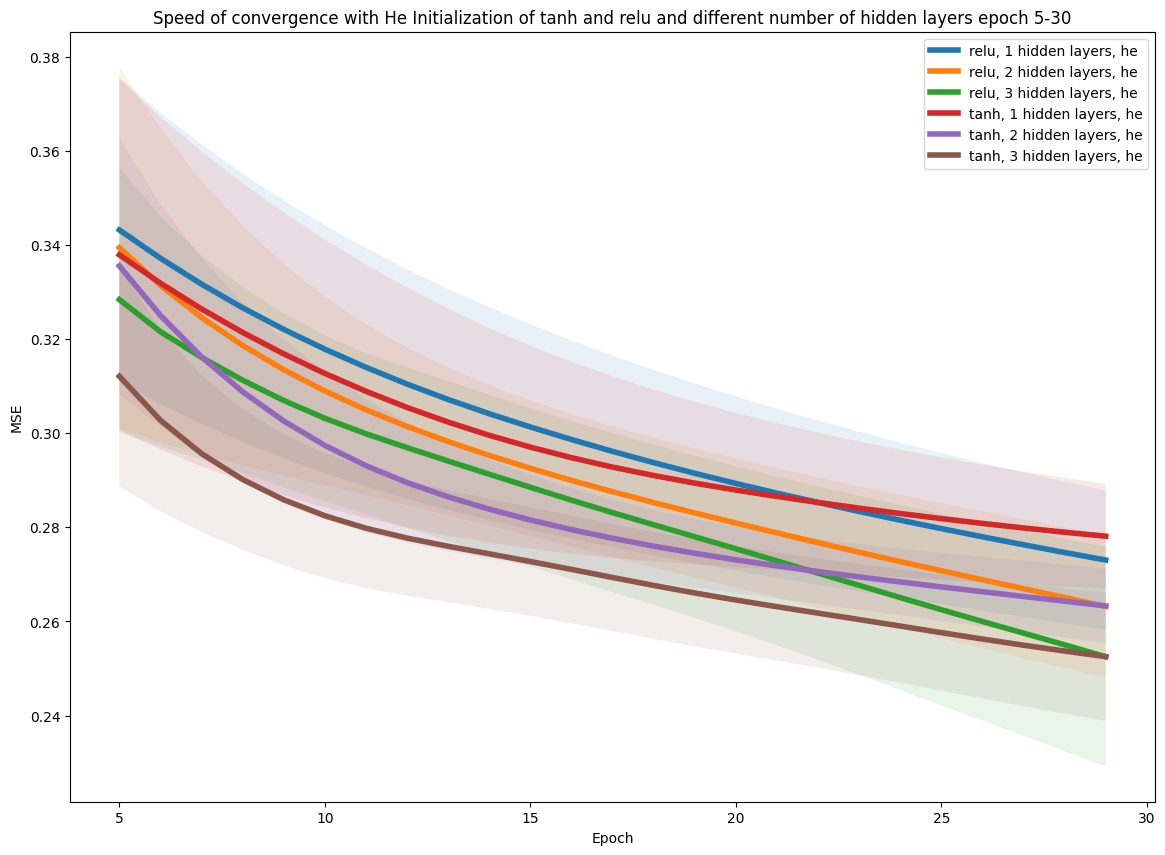

In [126]:
plt.figure(figsize=(14, 10))
start = 5
stop = 30  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers, {key[0]}"
    if (
        key[0]
        in [
            "he",
        ]
        and key[1] in ["tanh", "relu"]
        and key[2] in ["1", "2", "3"]
    ):
        plt.plot(
            range(start, stop),
            np.mean(value, axis=0)[start:stop],
            label=label,
            linewidth=4,
        )

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
        )

plt.legend()
plt.title(
    "Speed of convergence with He Initialization of tanh and relu and different number of hidden layers epoch 5-30"
)
plt.xlabel("Epoch")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

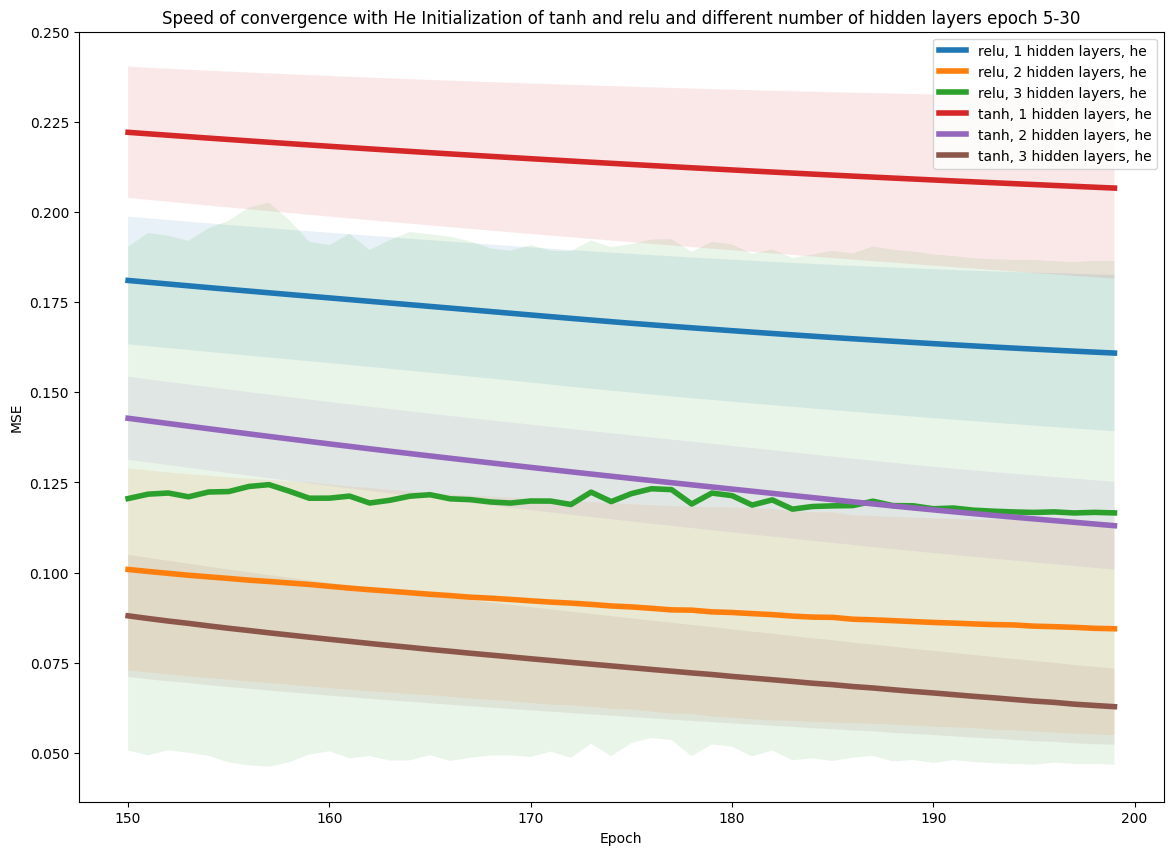

In [127]:
plt.figure(figsize=(14, 10))
start = 150
stop = 200  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers, {key[0]}"
    if (
        key[0]
        in [
            "he",
        ]
        and key[1] in ["tanh", "relu"]
        and key[2] in ["1", "2", "3"]
    ):
        plt.plot(
            range(start, stop),
            np.mean(value, axis=0)[start:stop],
            label=label,
            linewidth=4,
        )

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
        )

plt.legend()
plt.title(
    "Speed of convergence with He Initialization of tanh and relu and different number of hidden layers epoch 5-30"
)
plt.xlabel("Epoch")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

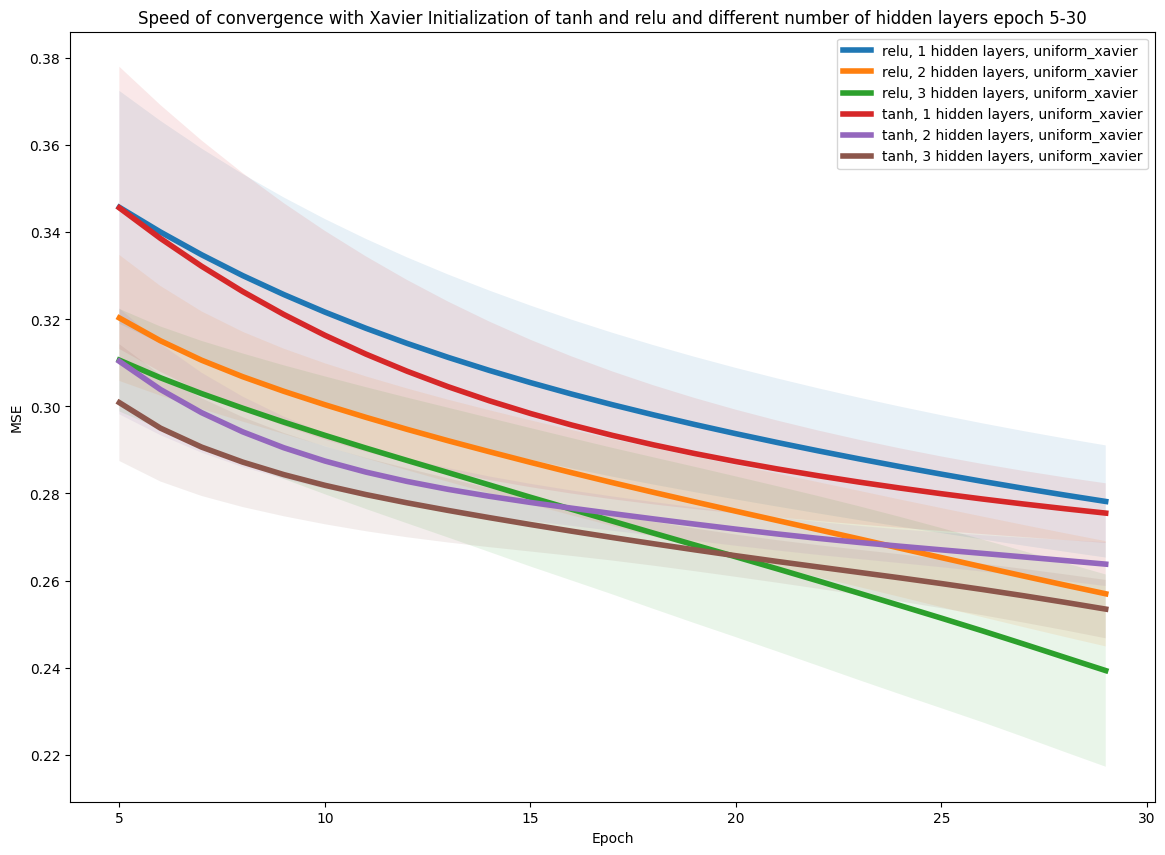

In [128]:
plt.figure(figsize=(14, 10))
start = 5
stop = 30  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers, {key[0]}"
    if (
        key[0]
        in [
            "uniform_xavier",
        ]
        and key[1] in ["tanh", "relu"]
        and key[2] in ["1", "2", "3"]
    ):
        plt.plot(
            range(start, stop),
            np.mean(value, axis=0)[start:stop],
            label=label,
            linewidth=4,
        )

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
        )

plt.legend()
plt.title(
    "Speed of convergence with Xavier Initialization of tanh and relu and different number of hidden layers epoch 5-30"
)
plt.xlabel("Epoch")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

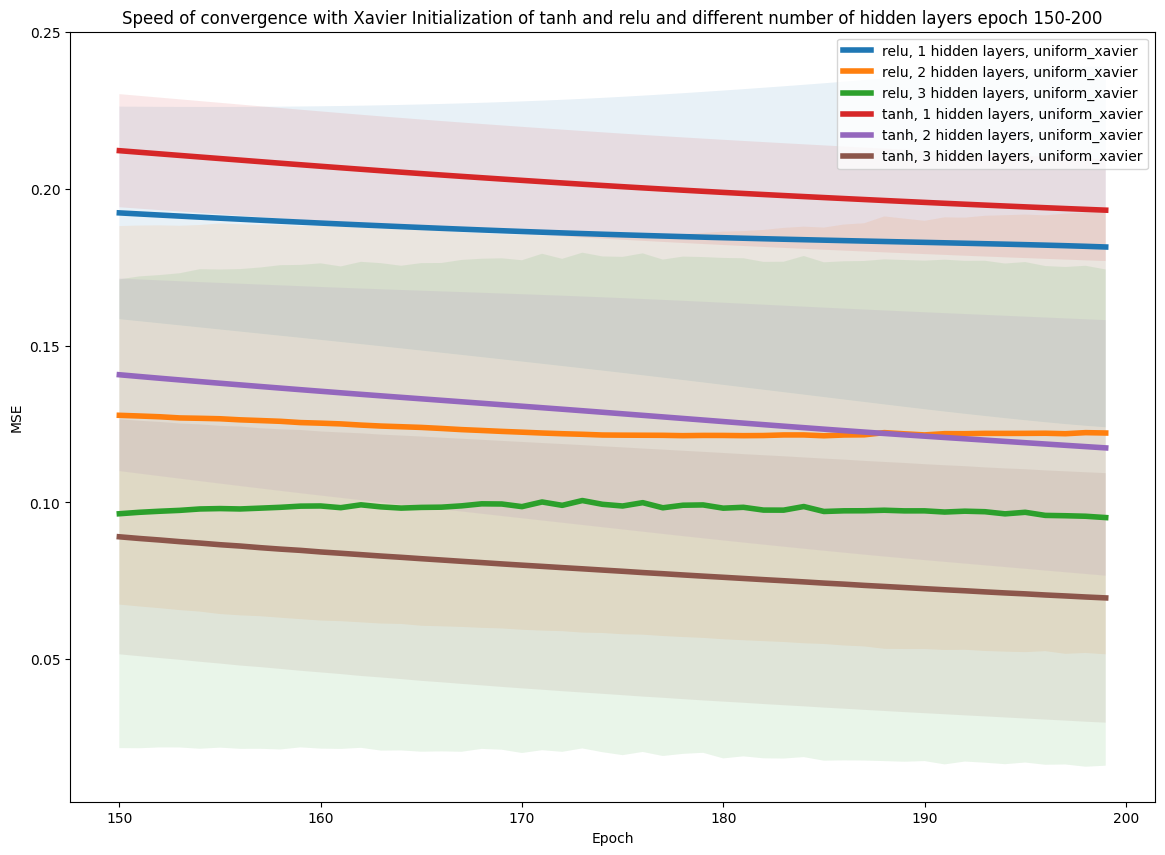

In [129]:
plt.figure(figsize=(14, 10))
start = 150
stop = 200  # len(after_epoch_dict["he/relu/1"][0])
for key, value in after_epoch_dict.items():
    key = key.split("/")
    label = f"{key[1]}, {key[2]} hidden layers, {key[0]}"
    if (
        key[0]
        in [
            "uniform_xavier",
        ]
        and key[1] in ["tanh", "relu"]
        and key[2] in ["1", "2", "3"]
    ):
        plt.plot(
            range(start, stop),
            np.mean(value, axis=0)[start:stop],
            label=label,
            linewidth=4,
        )

        plt.fill_between(
            range(start, stop),
            np.maximum(np.mean(value, axis=0) - np.std(value, axis=0), 0)[start:stop],
            np.mean(value, axis=0)[start:stop] + np.std(value, axis=0)[start:stop],
            alpha=0.1,
        )

plt.legend()
plt.title(
    "Speed of convergence with Xavier Initialization of tanh and relu and different number of hidden layers epoch 150-200"
)
plt.xlabel("Epoch")
plt.ylabel("MSE")

In [133]:
rings5_train["predicted"] = three_hidden.predict_class(x)
rings5_train["correct"] = rings5_train["c"] == rings5_train["predicted"]

rings5_test["predicted"] = three_hidden.predict_class(
    rings5_test[["x", "y"]].to_numpy()
)
rings5_test["correct"] = rings5_test["c"] == rings5_test["predicted"]

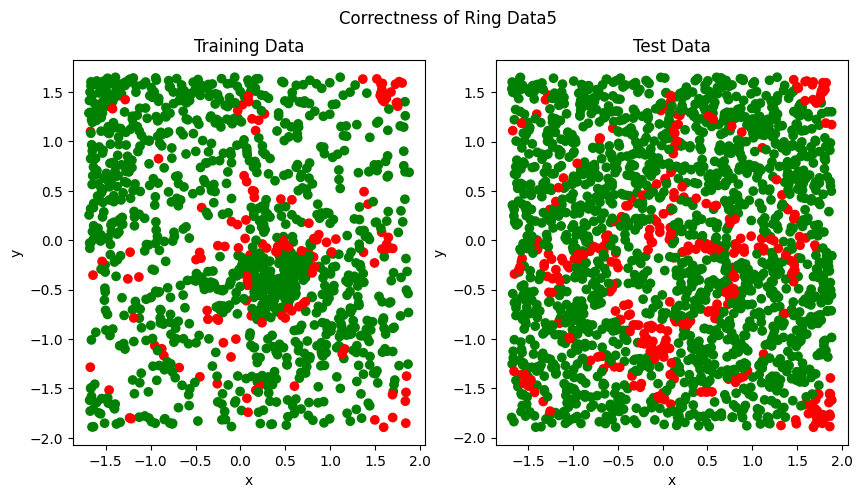

In [135]:
visualize_correctness(rings5_train, rings5_test, "Correctness of Ring Data5")

# Rings3

In [112]:
rings3_train = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/classification/rings3-regular-training.csv"
)
rings3_test = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/classification/rings3-regular-test.csv"
)
mean = rings3_train.mean()
std = rings3_train.std()
rings3_train = (rings3_train - mean) / std
rings3_test = (rings3_test - mean) / std

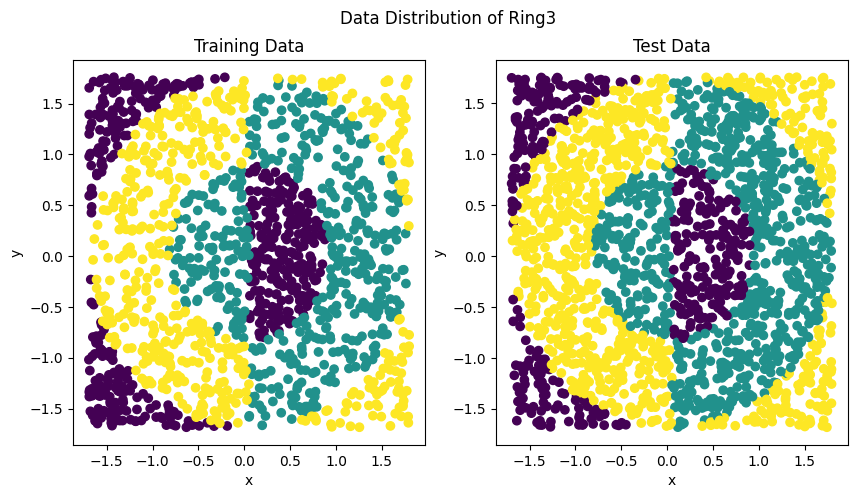

In [113]:
visualize_data_distribution(rings3_train, rings3_test, "Data Distribution of Ring3")

In [ ]:
activation_functions = ["relu", "tanh"]
initialization_methods = ["uniform_xavier", "he"]
number_of_repetition = 15
data = rings3_train
data_test = rings3_test

In [ ]:
from collections import defaultdict

df = pd.DataFrame(
    columns=[
        "Initialization",
        "Activation",
        "Hidden Layers",
        "Cost",
        "Computation Time",
    ]
)
after_epoch_dict = defaultdict(lambda: [])

for initialization_method in initialization_methods:
    for activation in activation_functions:
        for _ in range(number_of_repetition):
            # One hidden layer creation
            one_hidden = NeuralNetwork(cost_function="cross_entropy_with_softmax")
            one_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            one_hidden.add_layer(Layer(10, 1, "softmax"))

            # Two hidden layers creation
            two_hidden = NeuralNetwork(cost_function="cross_entropy_with_softmax")
            two_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            two_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            two_hidden.add_layer(Layer(10, 1, "softmax"))

            # Three hidden layers creation
            three_hidden = NeuralNetwork(cost_function="cross_entropy_with_softmax")
            three_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(Layer(10, 1, "softmax"))

            # Training
            time_start = time.time()
            one_cost_after_epoch = one_hidden.train(
                data["x"],
                data["y"],
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_first = time.time() - time_start
            two_cost_after_epoch = two_hidden.train(
                data["x"],
                data["y"],
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_second = time.time() - time_start - time_first
            three_cost_after_epoch = three_hidden.train(
                data["x"],
                data["y"],
                max_num_epoch=200,
                learning_rate=0.01,
                batch_fraction=1,
            )
            time_third = time.time() - time_start - time_first - time_second

            # Testing
            one_hidden_test_cost = one_hidden.calculate_cost(
                data_test["x"], data_test["y"]
            )
            two_hidden_test_cost = two_hidden.calculate_cost(
                data_test["x"], data_test["y"]
            )
            three_hidden_test_cost = three_hidden.calculate_cost(
                data_test["x"], data_test["y"]
            )

            # Saving cost after training results
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "1",
                one_hidden_test_cost,
                time_first,
            ]
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "2",
                two_hidden_test_cost,
                time_second,
            ]
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "3",
                three_hidden_test_cost,
                time_third,
            ]

            # Saving cost after epoch results
            after_epoch_dict[f"{initialization_method}/{activation}/1"].append(
                one_cost_after_epoch
            )
            after_epoch_dict[f"{initialization_method}/{activation}/2"].append(
                two_cost_after_epoch
            )
            after_epoch_dict[f"{initialization_method}/{activation}/3"].append(
                three_cost_after_epoch
            )
    print(f"Initialization method {initialization_method} done")